In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import os
import matplotlib.patches as patches

In [2]:
labels = ["Coleoptera", "Diptera", "Hemiptera", "Hymenoptera", "Lepidoptera", "Odonata"]

def get_label(id): 
    return labels[id]

### Reading the tf record files

In [3]:
tf_records_path = os.path.join(os.getcwd(), "dataset/records")
tf_records = [os.path.join(tf_records_path, path) for path in os.listdir(tf_records_path)]
print(f"found {len(tf_records)} tf records files")

found 63 tf records files


In [4]:
image_feature_description = {
    "image/encoded" : tf.io.FixedLenFeature([], tf.string),
    "image/obj/heights": tf.io.VarLenFeature(tf.float32),
    "image/obj/widths": tf.io.VarLenFeature(tf.float32),
    "image/obj/lefts": tf.io.VarLenFeature(tf.float32),
    "image/obj/tops": tf.io.VarLenFeature(tf.float32),
    "image/obj/class_id": tf.io.VarLenFeature(tf.int64)
}



def parse_function(example_proto): 
    """
        deserialize a raw record
    """
    example =  tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_image(example["image/encoded"], channels=3)

    image = tf.cast(image, dtype=tf.float32) / 255.0
    
    bboxes = tf.stack([
     tf.sparse.to_dense(example["image/obj/heights"]), 
     tf.sparse.to_dense(example["image/obj/widths"]), 
     tf.sparse.to_dense(example["image/obj/lefts"]), # be careful ! inverted with top !
     tf.sparse.to_dense(example["image/obj/tops"]) # be careful ! inverted with left ! 
    ], axis=-1)
    # resizing all images
        
    label = tf.stack(tf.sparse.to_dense(example["image/obj/class_id"]))
    
    return image, bboxes, label
    

### functions to manipulate bounding boxes 

In [5]:
def from_hwlt_to_xyxy(bboxes): 
    """
        convert a bboxs with format whlt to xmin ymin xmax ymax format
        Input: 
            a (n,4) tensor
    """
    
    return tf.stack([
        bboxes[:,3], 
        bboxes[:,2], 
        bboxes[:,3] + bboxes[:,1],
        bboxes[:,2] + bboxes[:,0]
    ], axis=-1)

def from_xyxy_to_xywh(bboxes): 
    return tf.stack(
        [(bboxes[:,0] + bboxes[:, 2]) / 2,
        (bboxes[:, 1] + bboxes[:, 3]) / 2,
        bboxes[:, 2] - bboxes[:,0], 
        bboxes[:, 3] - bboxes[:, 1]], 
        axis=-1
    )

def from_xywh_to_xyxy(bboxes): 
    return tf.concat(
        [(bboxes[..., :2] + bboxes[..., 2:]) / 2.0, bboxes[..., 2:] - bboxes[..., :2]],
        axis=-1,
    )

In [6]:
dataset_size = 8000

In [7]:
# opening the raw dataset out of the tf records files
raw_dataset = tf.data.TFRecordDataset(tf_records).take(dataset_size)
dataset = raw_dataset.map(parse_function)

In [8]:
def validate_dataset(filenames, reader_opts=None):
    """
    Attempt to iterate over every record in the supplied iterable of TFRecord filenames
    :param filenames: iterable of filenames to read
    :param reader_opts: (optional) tf.python_io.TFRecordOptions to use when constructing the record iterator
    """
    i = 0
    for fname in filenames:

        record_iterator =  tf.compat.v1.io.tf_record_iterator(path=fname, options=reader_opts)
        try:
            for _ in record_iterator:
                i += 1
        except Exception as e:
            print('error in {} at record {}'.format(fname, i))
            print(e)
            
validate_dataset(tf_records)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [9]:
def parse_bboxes(image, bboxes, label): 
    print(image, bboxes, label)
    return image, from_hwlt_to_xyxy(bboxes), label

dataset = dataset.map(parse_bboxes)

Tensor("args_0:0", dtype=float32) Tensor("args_1:0", shape=(None, 4), dtype=float32) Tensor("args_2:0", shape=(None,), dtype=int64)


### Visualizing the training data 

In [10]:
def visualize_example(image, bboxes, label):
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    
    boxes = bboxes * 448
    for bbox in boxes: 
        print(bbox)
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0] , bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.imshow(image) 
    plt.title(get_label(label.numpy()[0]))
    plt.show()
    

tf.Tensor([ 70.08684   72.996895 351.0517   396.37228 ], shape=(4,), dtype=float32)


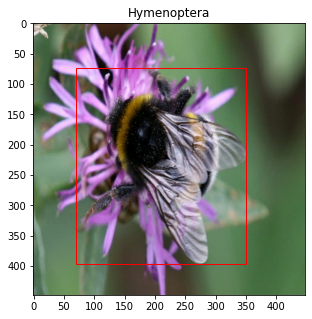

tf.Tensor([218.59683 228.66183 228.47693 252.75284], shape=(4,), dtype=float32)


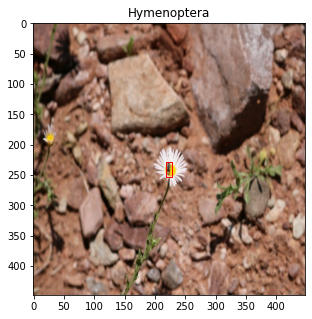

In [11]:
for image, bboxes, label in dataset.take(2):
    visualize_example(image, bboxes, label)

### Model hyperparameters 

In [24]:
width = 448 
height = 448
S = 7
cell_size = (width/ S, height/ S)
batch_size = 8
epochs = 100
nb_boxes = 2
lr = 0.00001

train_split = int(dataset_size * 0.9)
test_split = int(dataset_size * 0.1)

print(train_split, test_split)


7200 800


In [13]:
def encode_label(image, bboxes, label): 
    """
        given an bboxes and labels
        create a Yolo formatted label of size(SxS, K + 5*nb_boxes) 
        # Important : 
            the width and heights of the bboxes in the target tensor are normalized regarding the IMAGE WIDTH/HEIGHT
            the center coordinates (x,y) are normalized regarding the cell dimensions!
        Argument: 
            bboxes : a (n,4) tensor of xyxy coordinates
            label : a (n,) tensor 
    """
    output_tensor = np.zeros((S,S,5*nb_boxes + len(labels)))
    
    nb_items = tf.shape(bboxes)[0]
    
    boxes = from_xyxy_to_xywh(bboxes)
    one_hot = tf.one_hot(label, depth=len(labels),axis=1)
    centers = boxes[:,:2]
    wh = boxes[:,2:]
    
    grid_offsets = tf.math.floordiv(centers,int(cell_size[0])) # return the grid position of centers
    normalized_centers = centers / width - grid_offsets
    normalized_wh = wh / width
    
    confidence = tf.zeros((nb_items, 1))
    
    normalized_box = tf.concat([normalized_centers, normalized_wh], axis=-1) 
    
    targets = tf.concat([confidence, confidence, normalized_box,normalized_box, one_hot], axis=-1) 
    targets = tf.reshape(targets, [1, nb_items, 5*nb_boxes + len(labels)])
    targets = tf.cast(targets, tf.float64)
    
    indices = tf.concat([grid_offsets[:,1], grid_offsets[:,0]], axis=-1)
    indices = tf.reshape(indices, [1,nb_items, nb_boxes])
    indices = tf.cast(indices, tf.int32)
    
    output_tensor = tf.tensor_scatter_nd_update(output_tensor, indices, targets)
    print(output_tensor)
    return image, output_tensor
    
    # get centers and computer normalized coordinates
    

In [14]:
dataset = dataset.shuffle(512)
train_dataset = dataset.take(train_split) 
test_dataset = dataset.skip(train_split)

In [15]:
train_dataset = train_dataset.map(encode_label)
test_dataset = test_dataset.map(encode_label)

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)


Tensor("TensorScatterUpdate:0", shape=(7, 7, 16), dtype=float64)
Tensor("TensorScatterUpdate:0", shape=(7, 7, 16), dtype=float64)


In [16]:
def conv_block(tensor, filters, kernel_size, stride):
    x = tf.keras.layers.Conv2D(filters=filters,
                               kernel_size=kernel_size,
                               strides=stride,
                               padding='same',
                               use_bias=False,
                               kernel_initializer='he_normal')(tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.1)(x)
    return x


def build_model(H, W, num_classes):
    stride = 64
    grid_shape = [H // cell_size[0], W // cell_size[1]]

    image_input = tf.keras.Input(shape=[H, W, 3], name='image_input')
    x = conv_block(image_input, filters=16, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=32, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=64, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=128, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=256, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=512, kernel_size=3, stride=1)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = conv_block(x, filters=1024, kernel_size=3, stride=1)
    x = conv_block(x, filters=1024, kernel_size=3, stride=1)
    x = conv_block(x, filters=1024, kernel_size=3, stride=1)
    # Fully convolutional
    predictions = tf.keras.layers.Conv2D(filters=(2 * 5 + num_classes),
                                         kernel_size=1)(x)
    return tf.keras.Model(inputs=[image_input],
                          outputs=[predictions],
                          name='yolo')

In [17]:
def compute_iou(boxes1, boxes2): 
    """
        given two corner coordinates formatted bbox, return the IOU between the gt and the NBOXES other bbox 
        in a cell
    """
    
    corner_boxes1 = from_xywh_to_xyxy(boxes1) 
    corner_boxes2 = from_xywh_to_xyxy(boxes2)
    
    upper_left = tf.maximum(boxes1[...,2:], boxes2[...,2:])
    right_down = tf.minimum(boxes1[...,2:], boxes2[...,2:])
    
    
    intersection_area = (right_down[...,0] - upper_left[...,1]) * (right_down[...,0] - upper_left[...,1])
    intersection_area = tf.maximum(0.0,intersection_area)
    
    union1 = boxes1[...,2] * boxes1[...,3]
    union2 = boxes2[...,2] * boxes2[...,3]
    
    intersection_over_union = intersection_area / (union1 + union2 - intersection_area)
    
    return tf.clip_by_value(intersection_over_union, 0.0, 1.0)

In [18]:

class YoloLoss(tf.keras.losses.Loss): 
    
    def call(self,y_true, y_pred):
        """
            compute the yolo loss 
            Argument: 
                y_true : a (BS,S,S,5*nb_boxes + 6) tensor 
                y_pred : a (BS,S,S,5*nb_boxes + 6) tensor
        """

        true_conf = y_true[:,:,:,:nb_boxes]
        true_conf = tf.reshape(true_conf, [-1,S,S,nb_boxes,1])
        true_bboxes = y_true[:,:,:,nb_boxes:nb_boxes + 4*nb_boxes] # (bs,s,s,4*nb_boxes)
        resh_true_boxes = tf.reshape(true_bboxes, [-1, S, S, nb_boxes, 4])
        true_classes = y_true[:,:,:,nb_boxes + 4*nb_boxes:]
        true_classes = tf.reshape(true_classes, [-1, S, S, 1, len(labels)])


        pred_conf = y_pred[:,:,:,:nb_boxes] 
        pred_conf = tf.reshape(pred_conf, [-1,S,S,nb_boxes, 1])
        pred_bboxes = y_pred[:,:,:,nb_boxes:nb_boxes + 4*nb_boxes] # (bs,s,s,4*nb_boxes)
        resh_pred_boxes = tf.reshape(pred_bboxes, [-1, S, S, nb_boxes, 4])
        pred_classes = y_pred[:,:,:,nb_boxes + 4*nb_boxes:]
        pred_classes = tf.reshape(pred_classes, [-1, S, S, 1, len(labels)])


        # compute the iou 
        iou = compute_iou(resh_pred_boxes, resh_true_boxes) # (bs, s, s, 1) 
        max_iou = tf.reduce_max(iou)

        obj_mask = tf.where(iou < max_iou, 0.0, 1.0) 
        obj_mask = tf.reshape(obj_mask, [-1, S, S, nb_boxes, 1])

        obj_mask = tf.cast(obj_mask, dtype=tf.float32)

        no_obj_mask = tf.ones_like(obj_mask) - obj_mask
        center_loss = tf.reduce_sum(obj_mask * tf.square(resh_true_boxes[:,:,:,:,:2] - resh_pred_boxes[:,:,:,:,:2]))
        wh_loss = tf.reduce_sum(obj_mask * tf.square(tf.sqrt(resh_true_boxes[:,:,:,:,2:]) - resh_pred_boxes[:,:,:,:,2:]))
        conf_obj_loss = tf.reduce_sum(obj_mask * tf.square(iou - pred_conf))
        conf_noobj_loss = tf.reduce_sum(obj_mask * tf.square(pred_conf))

        cls_loss = tf.reduce_sum(true_conf * tf.square(pred_classes))

        loss =  5 * wh_loss + 5 * center_loss + conf_obj_loss + 0.5*conf_noobj_loss + cls_loss
        return loss
    

In [19]:
yolov1 = build_model(448,448, len(labels))
yolov1.summary()

Model: "yolo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 448, 448, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 448, 448, 16)      432       
_________________________________________________________________
batch_normalization (BatchNo (None, 448, 448, 16)      64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 448, 448, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128    

In [ ]:
class DecodePredictions(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs): 
        super(DecodePredictions, self).__init__(**kwargs)
        
    def call(self, y_pred):
        
        meshgrid = tf.stack([tf.meshgrid(range(S), range(S))], axis=-1) # (S,S,2)
        meshgrid = tf.reshape(meshgrid, [1, S, S, 1, 2]) # (-1, S, S, 1, 2)
        meshgrid = tf.tile(meshgrid, [1, 1, 1, 2, 2]) # (-1, S, S, S, 2, 2)
        
        pred_conf = y_pred[:,:,:,:nb_boxes] 
        pred_bbox = y_pred[:,:,:,nb_boxes: nb_boxes*4]
        pred_bbox = tf.reshape(pred_bbox, [-1, S, S, nb_boxes, 4]) 
        pred_cls = y_pred[:,:,:,nb_boxes*4 + nb_boxes:]
        
        denormalized_bbox = tf.concat([
            # (-1, S, S, 2, 2)
            (pred_bbox[:,:,:,:,:2] + meshgrid) * cell_size, 
            (pred_bbox[:,:,:,:,:]) * cell_size
        ],axis=-1) # (-1, S, S, 2, 4)
        
        denormalized_bbox = tf.reshape(denormalized_bbox, [-1, 4])
        
        cls = tf.expand_dims(tf.argmax(pred_cls, axis=-1), axis=-1) 
        cls = tf.tile(cls, [1, 1, 1, 2]) 
        cls = cls.reshape(cls, -1)
        
        cls_score = tf.reduce_max(pred_cls, axis=-1) 
        cls_score = tf.expand_dims(cls_score, axis=-1)
        cls_score = tf.tile(cls_score, [1,1,1,2])
        
        proba_score = pred_conf * cls_score
        proba_score = tf.reshape(proba_score, -1)
        
        denormalized_bbox = from_xywh_to_xyxy(denormalized_box)
        indices = tf.image.non_max_suppression(denormalized_bbox, cls_score, 100, iou_threshold, 0.5, 0.55)
        
        bbox = tf.gather(denormalized_bbox, indices)
        cls_score = tf.gather(cls_score, indices)
        cls_id = tf.gather(cls, indices)
        
        return bbox, cls_score, cls_id
        
        
        

In [25]:
def lr_decay(epoch, lr):
    if epoch < 3: 
        return lr 
    return lr * tf.math.exp(-0.2)
        

In [26]:
optimizer = tf.keras.optimizers.Adam(lr)

log_dir = "logs/fit/" + f"iou_yolov1_adam_lr{lr}_scheduling.h5"

callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1), 
]

yolov1.compile(
    optimizer=optimizer, 
    loss=YoloLoss()
)

In [27]:
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
test_dataset = test_dataset.apply(tf.data.experimental.ignore_errors())

In [28]:
hist = yolov1.fit(
    train_dataset,
    epochs=30, 
    callbacks=callbacks, 
    validation_data=test_dataset,
    shuffle=True, 
    batch_size=batch_size
)

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
900/900 [==============================] - 128s 122ms/step - loss: 218.4263 - val_loss: 23.4824

Epoch 00001: val_loss improved from inf to 23.48243, saving model to best_model.h5
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
900/900 [==============================] - 111s 123ms/step - loss: 16.9785 - val_loss: 11.0534

Epoch 00002: val_loss improved from 23.48243 to 11.05339, saving model to best_model.h5
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
900/900 [==============================] - 111s 123ms/step - loss: 7.7680 - val_loss: 85.0659

Epoch 00003: val_loss did not improve from 11.05339
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(8.187308e-06, shape=(), dtype=float32).
900/900 [==============================] - 110s 122ms/step - loss: 4.5705 - val_lo

900/900 [==============================] - 112s 124ms/step - loss: 0.9606 - val_loss: 0.1475

Epoch 00030: val_loss improved from 0.15559 to 0.14751, saving model to best_model.h5


In [29]:
yolov1 = tf.keras.models.load_model("best_model.h5", compile=False)

In [30]:
lr = 6.720542e-07
def lr_decay(epoch, lr):
    if epoch < 4: 
        return lr 
    return lr * tf.math.exp(-0.1)
        

In [33]:
yolov1.compile(
    optimizer=optimizer, 
    loss=YoloLoss()
)

optimizer = tf.keras.optimizers.Adam(lr)
log_dir = "logs/fit/" + f"iou_stopped1_yolov1_adam_lr{lr}_scheduling.h5"


callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('iou_stopped_best_model_V2.h5', save_best_only=True, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1), 
]


In [ ]:
hist = yolov1.fit(
    train_dataset,
    epochs=50, 
    callbacks=callbacks, 
    validation_data=test_dataset,
    shuffle=True, 
    batch_size=batch_size
)

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 6.720542273797037e-07.
900/900 [==============================] - 115s 126ms/step - loss: 0.5634 - val_loss: 0.1776

Epoch 00001: val_loss improved from inf to 0.17755, saving model to iou_stopped_best_model_V2.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 6.720542273797037e-07.
900/900 [==============================] - 111s 123ms/step - loss: 0.4383 - val_loss: 1.4402

Epoch 00002: val_loss did not improve from 0.17755
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 6.720542273797037e-07.
900/900 [==============================] - 111s 122ms/step - loss: 0.4874 - val_loss: 0.2693

Epoch 00003: val_loss did not improve from 0.17755
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 6.720542273797037e-07.
900/900 [==============================] - 111s 123ms/step - loss: 0.3962 - val_loss: 0.1537

Epoch 00004: val_loss improved from 0.17755 t

Epoch 31/50

Epoch 00031: LearningRateScheduler setting learning rate to tf.Tensor(4.5165677e-08, shape=(), dtype=float32).
306/900 [=========>....................] - ETA: 1:06 - loss: 0.1372